In [5]:
# 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.datasets import boston_housing
from keras.layers import Dense, Dropout
#from keras.utils import multi_gpu_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model

from keras import regularizers  # 正则化
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [17]:
# x_train = pd.read_excel('dataframe2.xlsx')
# y_train = pd.read_excel('location.xlsx',usecols=['x'])
# x_valid = pd.read_csv('data_t1.csv')
# y_valid = pd.read_excel('weizhi1.xlsx',usecols=['x'])
x_train = pd.read_excel('dataframe2.xlsx',nrows=55)
y_train = pd.read_excel('location.xlsx',usecols=['x'],nrows=55)
x_valid = pd.read_excel('dataframe2.xlsx',skiprows=range(1,55))
y_valid = pd.read_excel('location.xlsx',usecols=['x'],skiprows=range(1,55))
x_train_pd = pd.DataFrame(x_train)
y_train_pd = pd.DataFrame(y_train)
x_valid_pd = pd.DataFrame(x_valid)
y_valid_pd = pd.DataFrame(y_valid)
print(x_train_pd.head(5))
print('-------------------')
print(y_train_pd.head(5))
print(y_valid_pd.head(5))

        1到达时间ns  1幅度dB  1计数  1上升时间us       2到达时间ns  2幅度dB  2计数  2上升时间us  \
0    9267224050  90.63  424    313.6    9267220850  91.12  412   1234.4   
1   23652196450  90.28  374    288.0   23652197650  90.54  392    396.8   
2   37026769250  94.07  521   1158.8   37026814050  97.93  537    446.4   
3   92039737250  92.12  436   4885.1   92039735650  96.30  527    465.0   
4  108145405250  90.12  434    498.0  108145414050  94.13  455    448.4   

        3到达时间ns  3幅度dB  3计数  3上升时间us  
0    9267228050  89.24  459   2644.4  
1   23652240850  90.06  444   2520.8  
2   37026804850  99.52  607    953.6  
3   92039727250  94.75  543    836.3  
4  108145394850  92.94  515   1942.0  
-------------------
      x
0  19.0
1  17.8
2  17.2
3  18.9
4  17.8
      x
0  21.7
1  19.1
2  19.4
3  18.6
4  17.5


## 数据归一化

In [18]:
# 训练集归一化
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x_train_pd)
x_train = min_max_scaler.transform(x_train_pd)

min_max_scaler.fit(y_train_pd)
y_train = min_max_scaler.transform(y_train_pd)

# 验证集归一化
min_max_scaler.fit(x_valid_pd)
x_valid = min_max_scaler.transform(x_valid_pd)

min_max_scaler.fit(y_valid_pd)
y_valid = min_max_scaler.transform(y_valid_pd)



# map

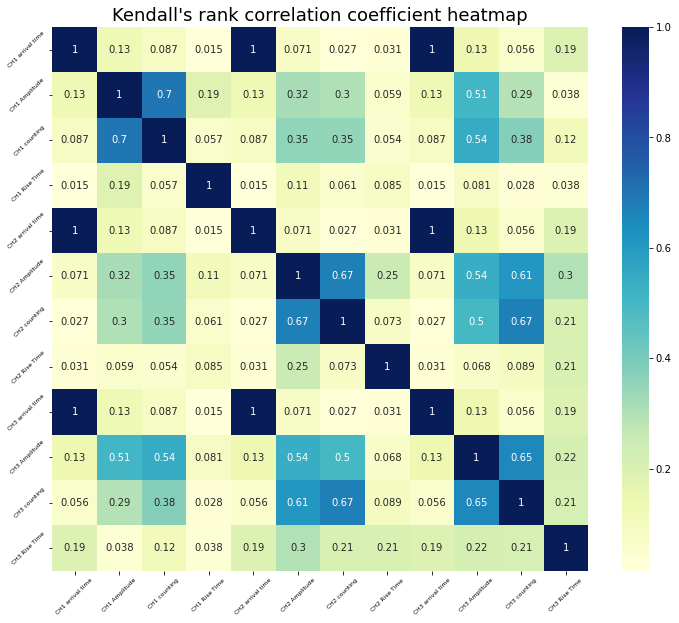

In [19]:
import seaborn as sns
x_train_pd = pd.DataFrame(x_train)
a = x_train_pd.corr("kendall").abs().values
#print(a)
fig, ax = plt.subplots(figsize = (12,10))
sns.heatmap(a,annot=True,xticklabels= True,yticklabels=True,cmap="YlGnBu")
ax.set_title('Kendall\'s rank correlation coefficient heatmap', fontsize = 18)
# ax.set_ylabel('数字', fontsize = 18)
# ax.set_xlabel('字母', fontsize = 18)
ax.set_xticklabels(['CH1 arrival time','CH1 Amplitude','CH1 counting','CH1 Rise Time',
                  'CH2 arrival time','CH2 Amplitude','CH2 counting','CH2 Rise Time',
                  'CH3 arrival time','CH3 Amplitude','CH3 counting','CH3 Rise Time'],
                   rotation=45,fontsize=6)
ax.set_yticklabels(['CH1 arrival time','CH1 Amplitude','CH1 counting','CH1 Rise Time',
                  'CH2 arrival time','CH2 Amplitude','CH2 counting','CH2 Rise Time',
                  'CH3 arrival time','CH3 Amplitude','CH3 counting','CH3 Rise Time'],
# ax.set_xticklabels(['CH1 arrival time','CH1 Amplitude','CH1 energy','CH1 counting','CH1 Duration',
#                   'CH2 arrival time','CH2 Amplitude','CH2 energy','CH2 counting','CH2 Duration',
#                   'CH3 arrival time','CH3 Amplitude','CH3 energy','CH3 counting','CH3 Duration'],
#                    rotation=45,fontsize=6)
# ax.set_yticklabels(['CH1 arrival time','CH1 Amplitude','CH1 energy','CH1 counting','CH1 Duration',
#                     'CH2 arrival time','CH2 Amplitude','CH2 energy','CH2 counting','CH2 Duration',
#                     'CH3 arrival time','CH3 Amplitude','CH3 energy','CH3 counting','CH3 Duration'],
                   rotation=45,fontsize=6)
plt.savefig('E:/论文写作/kendall-12p1.jpg',dpi=500)
#fig, ax = plt.subplots(figsize = (16,16))
#sns.heatmap(x_valid,annot=True)

### 训练

In [149]:
# 单CPU or GPU版本，若有GPU则自动切换
model = Sequential()  # 初始化，很重要！
model.add(Dense(units = 9,   # 输出大小
                activation='relu',  # 激励函数
                input_shape=(x_train_pd.shape[1],)  # 输入大小, 也就是列的大小
               )
         )

model.add(Dropout(0.2))  # 丢弃神经元链接概率

model.add(Dense(units =12,
              kernel_regularizer=regularizers.l2(0.01),  # 施加在权重上的正则项
             #activity_regularizer=regularizers.l1(0.01),  # 施加在输出上的正则项
                activation='relu' ,# 激励函数
                bias_regularizer=regularizers.l1_l2(0.01)  # 施加在偏置向量上的正则项
               )
         )

model.add(Dense(units = 1 ,   
                activation='linear'  # 线性激励函数 回归一般在输出层用这个激励函数  
               )
         )

print(model.summary())  # 打印网络层次结构

model.compile(loss='mse',  # 损失均方误差
              optimizer='adam',  # 优化器
             )

history = model.fit(x_train, y_train,
          epochs=700,  # 迭代次数
          batch_size=15,  # 每次用来梯度下降的批处理数据大小
          verbose=2,  # verbose：日志冗长度，int：冗长度，0：不输出训练过程，1：输出训练进度，2：输出每一个epoch
          validation_data = (x_valid, y_valid)  # 验证集
        )

# #多GPU版本
# parallel_model = multi_gpu_model(model, gpus=4)
# parallel_model.compile(loss='mse',  # 多分类     
#                        optimizer='adam',
#                       )

# #This `fit` call will be distributed on 4 GPUs.
# #Since the batch size is 50, each GPU will process 32 samples.
# batch_size = 512
# epochs = 2
# history = parallel_model.fit(
#           x_train, 
#           y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           validation_split = 0.2  # 从训练集分割出20%的数据作为验证集
#         )

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_123 (Dense)           (None, 9)                 117       
                                                                 
 dropout_41 (Dropout)        (None, 9)                 0         
                                                                 
 dense_124 (Dense)           (None, 12)                120       
                                                                 
 dense_125 (Dense)           (None, 1)                 13        
                                                                 
Total params: 250
Trainable params: 250
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/700
4/4 - 0s - loss: 0.4613 - val_loss: 0.2413 - 440ms/epoch - 110ms/step
Epoch 2/700
4/4 - 0s - loss: 0.3966 - val_loss: 0.2330 - 24ms/epoch - 6ms/step
Epoch 3/700
4/4 - 0s 

Epoch 92/700
4/4 - 0s - loss: 0.1181 - val_loss: 0.2449 - 22ms/epoch - 6ms/step
Epoch 93/700
4/4 - 0s - loss: 0.1135 - val_loss: 0.2491 - 21ms/epoch - 5ms/step
Epoch 94/700
4/4 - 0s - loss: 0.0978 - val_loss: 0.2480 - 21ms/epoch - 5ms/step
Epoch 95/700
4/4 - 0s - loss: 0.1020 - val_loss: 0.2536 - 23ms/epoch - 6ms/step
Epoch 96/700
4/4 - 0s - loss: 0.1127 - val_loss: 0.2526 - 20ms/epoch - 5ms/step
Epoch 97/700
4/4 - 0s - loss: 0.1087 - val_loss: 0.2493 - 21ms/epoch - 5ms/step
Epoch 98/700
4/4 - 0s - loss: 0.1106 - val_loss: 0.2531 - 21ms/epoch - 5ms/step
Epoch 99/700
4/4 - 0s - loss: 0.1049 - val_loss: 0.2598 - 20ms/epoch - 5ms/step
Epoch 100/700
4/4 - 0s - loss: 0.1113 - val_loss: 0.2571 - 20ms/epoch - 5ms/step
Epoch 101/700
4/4 - 0s - loss: 0.0993 - val_loss: 0.2483 - 24ms/epoch - 6ms/step
Epoch 102/700
4/4 - 0s - loss: 0.1249 - val_loss: 0.2372 - 25ms/epoch - 6ms/step
Epoch 103/700
4/4 - 0s - loss: 0.0949 - val_loss: 0.2347 - 27ms/epoch - 7ms/step
Epoch 104/700
4/4 - 0s - loss: 0.089

Epoch 194/700
4/4 - 0s - loss: 0.0731 - val_loss: 0.2411 - 20ms/epoch - 5ms/step
Epoch 195/700
4/4 - 0s - loss: 0.0691 - val_loss: 0.2384 - 19ms/epoch - 5ms/step
Epoch 196/700
4/4 - 0s - loss: 0.0794 - val_loss: 0.2331 - 19ms/epoch - 5ms/step
Epoch 197/700
4/4 - 0s - loss: 0.0637 - val_loss: 0.2286 - 22ms/epoch - 6ms/step
Epoch 198/700
4/4 - 0s - loss: 0.0684 - val_loss: 0.2290 - 24ms/epoch - 6ms/step
Epoch 199/700
4/4 - 0s - loss: 0.0763 - val_loss: 0.2296 - 22ms/epoch - 6ms/step
Epoch 200/700
4/4 - 0s - loss: 0.0744 - val_loss: 0.2375 - 21ms/epoch - 5ms/step
Epoch 201/700
4/4 - 0s - loss: 0.0681 - val_loss: 0.2400 - 20ms/epoch - 5ms/step
Epoch 202/700
4/4 - 0s - loss: 0.0758 - val_loss: 0.2413 - 20ms/epoch - 5ms/step
Epoch 203/700
4/4 - 0s - loss: 0.0722 - val_loss: 0.2453 - 20ms/epoch - 5ms/step
Epoch 204/700
4/4 - 0s - loss: 0.0765 - val_loss: 0.2393 - 18ms/epoch - 5ms/step
Epoch 205/700
4/4 - 0s - loss: 0.0745 - val_loss: 0.2356 - 20ms/epoch - 5ms/step
Epoch 206/700
4/4 - 0s - los

Epoch 296/700
4/4 - 0s - loss: 0.0581 - val_loss: 0.2307 - 20ms/epoch - 5ms/step
Epoch 297/700
4/4 - 0s - loss: 0.0598 - val_loss: 0.2376 - 23ms/epoch - 6ms/step
Epoch 298/700
4/4 - 0s - loss: 0.0616 - val_loss: 0.2400 - 21ms/epoch - 5ms/step
Epoch 299/700
4/4 - 0s - loss: 0.0577 - val_loss: 0.2353 - 20ms/epoch - 5ms/step
Epoch 300/700
4/4 - 0s - loss: 0.0609 - val_loss: 0.2338 - 22ms/epoch - 5ms/step
Epoch 301/700
4/4 - 0s - loss: 0.0677 - val_loss: 0.2265 - 22ms/epoch - 5ms/step
Epoch 302/700
4/4 - 0s - loss: 0.0559 - val_loss: 0.2253 - 21ms/epoch - 5ms/step
Epoch 303/700
4/4 - 0s - loss: 0.0593 - val_loss: 0.2250 - 23ms/epoch - 6ms/step
Epoch 304/700
4/4 - 0s - loss: 0.0620 - val_loss: 0.2270 - 22ms/epoch - 6ms/step
Epoch 305/700
4/4 - 0s - loss: 0.0699 - val_loss: 0.2345 - 20ms/epoch - 5ms/step
Epoch 306/700
4/4 - 0s - loss: 0.0585 - val_loss: 0.2398 - 20ms/epoch - 5ms/step
Epoch 307/700
4/4 - 0s - loss: 0.0575 - val_loss: 0.2397 - 23ms/epoch - 6ms/step
Epoch 308/700
4/4 - 0s - los

Epoch 398/700
4/4 - 0s - loss: 0.0583 - val_loss: 0.2060 - 20ms/epoch - 5ms/step
Epoch 399/700
4/4 - 0s - loss: 0.0462 - val_loss: 0.2096 - 22ms/epoch - 6ms/step
Epoch 400/700
4/4 - 0s - loss: 0.0601 - val_loss: 0.2094 - 20ms/epoch - 5ms/step
Epoch 401/700
4/4 - 0s - loss: 0.0585 - val_loss: 0.2076 - 19ms/epoch - 5ms/step
Epoch 402/700
4/4 - 0s - loss: 0.0572 - val_loss: 0.2086 - 20ms/epoch - 5ms/step
Epoch 403/700
4/4 - 0s - loss: 0.0478 - val_loss: 0.2106 - 23ms/epoch - 6ms/step
Epoch 404/700
4/4 - 0s - loss: 0.0550 - val_loss: 0.2175 - 21ms/epoch - 5ms/step
Epoch 405/700
4/4 - 0s - loss: 0.0517 - val_loss: 0.2295 - 27ms/epoch - 7ms/step
Epoch 406/700
4/4 - 0s - loss: 0.0620 - val_loss: 0.2361 - 21ms/epoch - 5ms/step
Epoch 407/700
4/4 - 0s - loss: 0.0569 - val_loss: 0.2183 - 20ms/epoch - 5ms/step
Epoch 408/700
4/4 - 0s - loss: 0.0465 - val_loss: 0.2060 - 19ms/epoch - 5ms/step
Epoch 409/700
4/4 - 0s - loss: 0.0467 - val_loss: 0.1988 - 20ms/epoch - 5ms/step
Epoch 410/700
4/4 - 0s - los

Epoch 500/700
4/4 - 0s - loss: 0.0458 - val_loss: 0.1927 - 21ms/epoch - 5ms/step
Epoch 501/700
4/4 - 0s - loss: 0.0404 - val_loss: 0.1954 - 21ms/epoch - 5ms/step
Epoch 502/700
4/4 - 0s - loss: 0.0476 - val_loss: 0.2045 - 22ms/epoch - 6ms/step
Epoch 503/700
4/4 - 0s - loss: 0.0464 - val_loss: 0.2036 - 19ms/epoch - 5ms/step
Epoch 504/700
4/4 - 0s - loss: 0.0569 - val_loss: 0.2014 - 20ms/epoch - 5ms/step
Epoch 505/700
4/4 - 0s - loss: 0.0474 - val_loss: 0.2004 - 19ms/epoch - 5ms/step
Epoch 506/700
4/4 - 0s - loss: 0.0425 - val_loss: 0.2093 - 21ms/epoch - 5ms/step
Epoch 507/700
4/4 - 0s - loss: 0.0512 - val_loss: 0.2097 - 21ms/epoch - 5ms/step
Epoch 508/700
4/4 - 0s - loss: 0.0460 - val_loss: 0.2217 - 19ms/epoch - 5ms/step
Epoch 509/700
4/4 - 0s - loss: 0.0498 - val_loss: 0.2198 - 18ms/epoch - 5ms/step
Epoch 510/700
4/4 - 0s - loss: 0.0473 - val_loss: 0.2063 - 21ms/epoch - 5ms/step
Epoch 511/700
4/4 - 0s - loss: 0.0399 - val_loss: 0.2005 - 23ms/epoch - 6ms/step
Epoch 512/700
4/4 - 0s - los

4/4 - 0s - loss: 0.0441 - val_loss: 0.1968 - 40ms/epoch - 10ms/step
Epoch 602/700
4/4 - 0s - loss: 0.0414 - val_loss: 0.2052 - 30ms/epoch - 8ms/step
Epoch 603/700
4/4 - 0s - loss: 0.0415 - val_loss: 0.2103 - 29ms/epoch - 7ms/step
Epoch 604/700
4/4 - 0s - loss: 0.0423 - val_loss: 0.2078 - 31ms/epoch - 8ms/step
Epoch 605/700
4/4 - 0s - loss: 0.0353 - val_loss: 0.2000 - 22ms/epoch - 6ms/step
Epoch 606/700
4/4 - 0s - loss: 0.0468 - val_loss: 0.1927 - 27ms/epoch - 7ms/step
Epoch 607/700
4/4 - 0s - loss: 0.0435 - val_loss: 0.1928 - 20ms/epoch - 5ms/step
Epoch 608/700
4/4 - 0s - loss: 0.0336 - val_loss: 0.1942 - 22ms/epoch - 6ms/step
Epoch 609/700
4/4 - 0s - loss: 0.0572 - val_loss: 0.1935 - 20ms/epoch - 5ms/step
Epoch 610/700
4/4 - 0s - loss: 0.0367 - val_loss: 0.1899 - 18ms/epoch - 5ms/step
Epoch 611/700
4/4 - 0s - loss: 0.0424 - val_loss: 0.1899 - 22ms/epoch - 6ms/step
Epoch 612/700
4/4 - 0s - loss: 0.0526 - val_loss: 0.1992 - 20ms/epoch - 5ms/step
Epoch 613/700
4/4 - 0s - loss: 0.0448 - v

#### 训练过程可视化

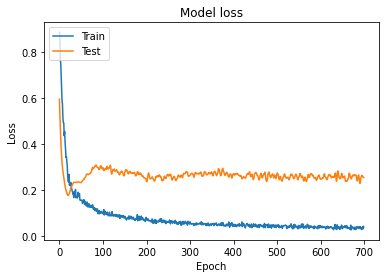

In [144]:
import matplotlib.pyplot as plt
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

##### 保存模型

In [145]:
#from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
from keras.models import load_model
# 保存模型
model.save('model_MLP.h5')  # creates a HDF5 file 'my_model.h5'

#模型可视化 pip install pydot
plot_model(model, to_file='model_MLP.png', show_shapes=True)

# 加载模型
model = load_model('model_MLP.h5')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


######  模型预测

In [146]:
# 预测
y_new = model.predict(x_valid)
# 反归一化
#min_max_scaler.fit(y_valid_pd)

y_new=min_max_scaler.inverse_transform(y_new)
print(y_new)

[[29.064943]
 [22.309153]
 [23.07357 ]
 [21.454887]
 [24.75918 ]
 [30.951616]
 [24.209318]
 [27.059055]
 [27.333952]
 [26.030012]
 [26.733706]]
